# Set up run

In [1]:
!pip install rasterio

In [2]:
#-- Set up configurations / parameters
retrain = False # retrain previously existing model
ndown = 4 # number of 'down' steps
ninit = 32 #number of channels to start with
dropout_frac = 0.2 # dropout fraction
n_batch = 10
n_epochs = 60
dilation_kernel = 3 #-- kernel size for increasing thickness of training labels
dilate = False
augment = False
suffix = ''
if dilate:
  suffix += '_dilated'
if augment:
  suffix += '_augmented'
  aug_num = 4
else:
  aug_num = 1
mod_lbl = 'atrous' #'unet'
if mod_lbl == 'unet':
  mod_str = '{0}_{1}init_{2}down_drop{3:.1f}{4}'.format(mod_lbl,ninit,ndown,
                                                        dropout_frac,suffix)
elif mod_lbl == 'atrous':
  mod_str = '{0}_{1}init_drop{2:.1f}{3}'.format(mod_lbl,ninit,dropout_frac,
                                                suffix)
else:
  print('model label not matching.')
print(mod_str)

atrous_32init_drop0.2


In [3]:
#-- Import Modules
import os
import imp
# import cv2
import numpy as np
import rasterio
# import geopandas as gpd
import matplotlib.pyplot as plt 
from google.colab import drive
import keras
from keras import backend as K
from keras.preprocessing import image
from tensorflow.python.client import device_lib
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from skimage.morphology import binary_dilation

Using TensorFlow backend.


In [4]:
#-- Print backend information
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11116899075421257712
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6839147975905356147
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4061732023652160835
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11395293509034724296
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]




['/job:localhost/replica:0/task:0/device:GPU:0']


In [5]:
#-- Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Train on data slant range imagery

In [0]:
#-- Directory setup
colabdir = '/content/gdrive/My Drive/Colab Notebooks/'
ddir = '/content/gdrive/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/'
train_dir = os.path.join(ddir,'Slant_Imagery','training_data')
test_dir = os.path.join(ddir,'Slant_Imagery','testing_data')

In [0]:
#-- Get list of images
fileList = os.listdir(train_dir)
train_list = [f for f in fileList if f.endswith('_coco.tif')]
fileList = os.listdir(test_dir)
test_list = [f for f in fileList if f.endswith('_coco.tif')]

In [8]:
#-- Read sample image to get dimensions
raster = rasterio.open(os.path.join(train_dir,train_list[15]))
im = raster.read(1)
channels = raster.count
raster.meta

{'count': 3,
 'crs': None,
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 512,
 'nodata': None,
 'transform': Affine(0.0, 0.0, 0.0,
       0.0, 0.0, 0.0),
 'width': 512}

In [0]:
if dilate:
  #-- Experiment with dilation training labels
  raster = rasterio.open(os.path.join(train_dir,train_list[15].replace('_coco.tif','_mask.tif')))
  tr1 = raster.read(1)
  #kernel = np.ones((dilation_kernel,dilation_kernel),np.uint8)
  #tr2 = cv2.dilate(tr1,kernel,iterations = 1)
  tr2 = binary_dilation(tr1)
  plt.figure(1,figsize=(8,8))
  plt.imshow(tr1)
  plt.figure(2,figsize=(8,8))
  plt.imshow(tr2)
  plt.show()

In [0]:
#-- Read training images
#-- Read training data with augmentation
train_imgs = np.ones((len(train_list)*aug_num,im.shape[0],im.shape[1],channels))
train_lbls = np.ones((len(train_list)*aug_num,im.shape[0],im.shape[1],1))
i = 0
for f in train_list:
    #-- read image
    raster = rasterio.open(os.path.join(train_dir,f))
    for c in range(channels):
        train_imgs[i,:,:,c] = raster.read(c+1)
        if augment:
          train_imgs[i+1,:,:,c] = np.fliplr(raster.read(c+1))
          train_imgs[i+2,:,:,c] = np.flipud(raster.read(c+1))
          train_imgs[i+3,:,:,c] = np.fliplr(np.flipud(raster.read(c+1)))
    #-- read label
    raster = rasterio.open(os.path.join(train_dir,f.replace('coco.tif','mask.tif')))
    if dilate:
      train_lbls[i,:,:,0] = binary_dilation(raster.read(1))
      if augment:
        train_lbls[i+1,:,:,0] = binary_dilation(np.fliplr(raster.read(1)))
        train_lbls[i+2,:,:,0] = binary_dilation(np.flipud(raster.read(1)))
        train_lbls[i+3,:,:,0] = binary_dilation(np.fliplr(np.flipud(raster.read(1))))
    else:
      train_lbls[i,:,:,0] = raster.read(1)
      if augment:
        train_lbls[i+1,:,:,0] = np.fliplr(raster.read(1))
        train_lbls[i+2,:,:,0] = np.flipud(raster.read(1))
        train_lbls[i+3,:,:,0] = np.fliplr(np.flipud(raster.read(1)))
    i += aug_num

#-- Read test data
test_imgs = np.ones((len(test_list),im.shape[0],im.shape[1],channels))
# test_lbls = np.ones((len(test_list),im.shape[0],im.shape[1],1))
for i,f in enumerate(test_list):
    #-- read image
    raster = rasterio.open(os.path.join(test_dir,f))
    for c in range(channels):
        test_imgs[i,:,:,c] = raster.read(c+1) #.transpose()
    #-- read label
    # raster = rasterio.open(os.path.join(test_dir,f.replace('coco.tif','mask.tif')))
    # test_lbls[i,:,:,0] = binary_dilation(raster.read(1))

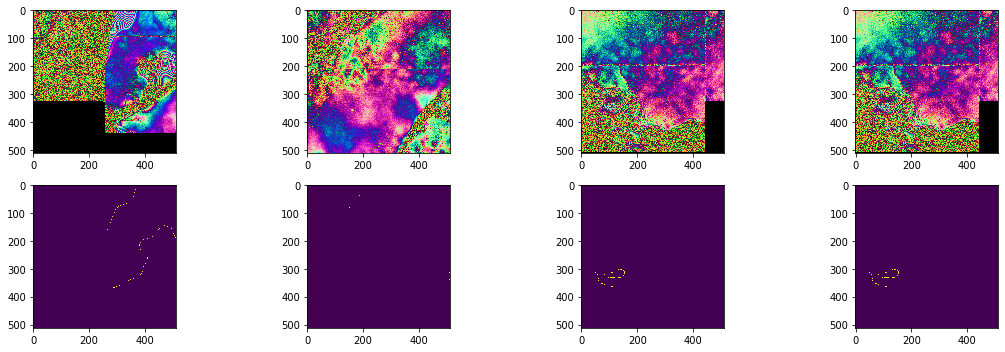

In [11]:
ncols = 4
fig,ax = plt.subplots(2, ncols,figsize=(16,5))
for k,j in zip(range(ncols),[80,81,82,83]): #,np.arange(0,10*ncols,10)):
  ax[0,k].imshow(train_imgs[j])
  ax[1,k].imshow(train_lbls[j].reshape((train_lbls.shape[1],train_lbls.shape[2])))
plt.tight_layout()
plt.show()

In [12]:
#-- get ratio of GL to non-GL pixels to use as weight in training
#-- First flatten labels for future use
n,h,wi,nch = train_imgs.shape
print(train_imgs.shape)
train_lbls = train_lbls.reshape((n,h*wi,1))
#-- count the proportion of white pixels to black pixels
GL_tot = 0
non_tot = 0
tot_size =h*wi
for i in range(n):
    GL_count = np.count_nonzero(train_lbls[i])
    GL_tot += GL_count
    non_tot += tot_size - GL_count

ratio = np.float(non_tot)/np.float(GL_tot)
print(ratio)

(155, 512, 512, 3)
727.0994875103036


In [13]:
#-- Set weights
#-- get rid of last dimension of training labels
train_lbls = train_lbls.reshape((n,h*wi))
#-- initialize weights
w = np.ones(train_lbls.shape)
#-- loop through images
for i in range(n):
    #-- flatten out image and get indices of boundaries
    ind = np.nonzero(train_lbls[i])
    w[i][ind] *= ratio
print(w.shape)
#-- convert Y_train back to original shape
train_lbls = train_lbls.reshape((train_lbls.shape[0],train_lbls.shape[1],1))
print(train_lbls.shape)

(155, 262144)
(155, 262144, 1)


In [14]:
#-- Upgrade U-Net model from TF1 to TF2
!tf_upgrade_v2 \
  --infile /content/gdrive/My\ Drive/Colab\ Notebooks/unet_model.py \
  --outfile /content/gdrive/My\ Drive/Colab\ Notebooks/unet_model_v2.py

TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 1 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'



In [15]:
#-- Import model
mod_module = imp.load_source('unet_model',os.path.join(colabdir,'unet_model.py'))
#-- set up model
if mod_lbl == 'unet':
  print('loading unet model')
  model = mod_module.unet_model_double_dropout(height=h,width=wi,channels=channels, 
                                        n_init=ninit,n_layers=ndown,
                                        drop=dropout_frac)
elif mod_lbl == 'atrous':
  print("loading atrous model")
  model = mod_module.unet_model_atrous_double_dropout(height=h,width=wi,
                                                channels=channels,
                                                n_filts=ninit,
                                                drop=dropout_frac)
else:
  print('Model label not correct.')

loading atrous model




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [16]:
#-- compile imported model
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'],sample_weight_mode="temporal")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
#-- checkpoint file
chk_file = os.path.join(colabdir,'{0}_weights.h5'.format(mod_str))

#-- if file exists, read model from file
if os.path.isfile(chk_file):
  print('Check point exists; loading model from file.')
  #-- load weights
  model.load_weights(chk_file)
else:
  print('Model does not previously exist.')

Model does not previously exist.


In [18]:
#-- Train the model
if (retrain) or (not os.path.isfile(chk_file)):
  print('Training model...')
  #-- create checkpoint
  model_checkpoint = keras.callbacks.ModelCheckpoint(chk_file, monitor='loss',
                                                     verbose=1, 
                                                     save_best_only=True)
  lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                  verbose=1, mode='auto', min_delta=0.0001, 
                                  cooldown=0, min_lr=0)
  # es_callback = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=5,
  #    verbose=1, mode='auto')
  #-- now fit the model
  history = model.fit(train_imgs, train_lbls, batch_size=n_batch, epochs=n_epochs, 
                      verbose=1, validation_split=0.1, shuffle=True, 
                      sample_weight=w,
                      callbacks=[lr_callback,model_checkpoint])
                      #callbacks=[lr_callback,es_callback,model_checkpoint])

  #-- save history to file
  outfile = open(os.path.join(colabdir,
                        '{0}_history.txt'
                        .format(mod_str)),'w')
  outfile.write('Epoch loss\tval_loss\tacc\tval_acc\n')
  for i in range(len(history.history['loss'])):
      outfile.write('%i\t%f\t%f\t%f\t%f\n'%(i,history.history['loss'][i],history.history['val_loss'][i],\
          history.history['acc'][i],history.history['val_acc'][i]))
  outfile.close()

  #-- Make plots for training history
  for item,name in zip(['acc','loss'],['Accuracy','Loss']):
    fig = plt.figure(1,figsize=(8,6))
    plt.plot(history.history[item])
    plt.plot(history.history['val_%s'%item])
    plt.title('Model %s'%name)
    plt.ylabel(name)
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(colabdir,
                        '{0}_history.pdf'
                        .format(mod_str)),format='pdf')
    plt.close(fig)

Training model...


Train on 139 samples, validate on 16 samples
Epoch 1/60


139/139 [==============================] - 14s 104ms/step - loss: 1.4148 - acc: 0.4826 - val_loss: 1.3247 - val_acc: 0.3281

Epoch 00001: loss improved from inf to 1.41484, saving model to /content/gdrive/My Drive/Colab Notebooks/atrous_32init_drop0.2_weights.h5
Epoch 2/60
139/139 [==============================] - 7s 47ms/step - loss: 1.3235 - acc: 0.4483 - val_loss: 1.3029 - val_acc: 0.2907

Epoch 00002: loss improved from 1.41484 to 1.32354, saving model to /content/gdrive/My Drive/Colab Notebooks/atrous_32init_drop0.2_weights.h5
Epoch 3/60
139/139 [==============================] - 7s 47ms/step - loss: 1.2982 - acc: 0.4637 - val_loss: 1.4634 - val_acc: 0.9918

Epoch 00003: loss improved from 1.32354 to 1.29822, saving model to /content/gdrive/My Drive/Colab Notebooks/atrous_32init_drop0.2_weights.h5
Epoch 4/60
139/139 [==============================] - 7s 47ms/step - loss: 1.3642 - acc: 0.4689 - val_loss:

In [19]:
print('Model is trained. Running on Train data...')
#-------------------------------
#-- First run on training data
#-------------------------------
out_imgs = model.predict(train_imgs, batch_size=1, verbose=1)
out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])
print(out_imgs.shape)

#-- make output directory
out_dir = os.path.join(colabdir,'Train_predictions.dir',
                       '{0}.dir'.format(mod_str))
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)

#-- save output images (every 4th image. Not interested in augmented cases)
for i,f in enumerate(train_list):
  im = image.array_to_img(out_imgs[aug_num*i]) 
  im.save(os.path.join(out_dir,f.replace('coco.tif','pred.png')))

Model is trained. Running on Train data...
155/155 [==============================] - 3s 18ms/step
(155, 512, 512, 1)


In [20]:
print(np.max(out_imgs))
print(np.min(out_imgs))

0.917655
0.0


In [21]:
#-------------------------------
#-- Run on test data
#-------------------------------
out_imgs = model.predict(test_imgs, batch_size=1, verbose=1)
out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])
print(out_imgs.shape)

#-- make output directory
out_dir = os.path.join(colabdir,'Test_predictions.dir',
                       '{0}.dir'.format(mod_str))
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)

#-- save output images
for i,f in enumerate(test_list):
  im = image.array_to_img(out_imgs[i]) 
  im.save(os.path.join(out_dir,f.replace('coco.tif','pred.png')))

34/34 [==============================] - 1s 16ms/step
(34, 512, 512, 1)


# Train on geocoded data

In [22]:
"""
dat_dir = '/content/gdrive/My Drive/GL_learning/GL_learning_data/Test_Training/2018_Track069'
#-- archives to read
fileList = []
for i in range(1,7):
    fileList += os.listdir(os.path.join(dat_dir,'Archive_%02i'%i))
tif_list = [f for f in fileList if f.endswith('.tif')]
"""

"\ndat_dir = '/content/gdrive/My Drive/GL_learning/GL_learning_data/Test_Training/2018_Track069'\n#-- archives to read\nfileList = []\nfor i in range(1,7):\n    fileList += os.listdir(os.path.join(dat_dir,'Archive_%02i'%i))\ntif_list = [f for f in fileList if f.endswith('.tif')]\n"